# Курсовой проект для курса "Python для Data Science"

## Задание для курсового проекта - Real Estate Price Prediction

Сдача проекта:
1. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту")
**ссылку на файл YourName_solution.ipynb**. (Pull request не нужен).
2. Приложить файл с названием по образцу **YourName_predictions.csv**
с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).
В файле с предсказаниями должна быть 5001 строка (шапка + 5000 предсказаний). 

Сроки и условия сдачи:

1. Сдать проект нужно в течение **6 дней** после начала Урока 10 ("Вебинар. Консультация по итоговому проекту") - до воскресенья 20:00.
2. Для успешной сдачи должны быть все предсказания (для 5000 квартир) и R2 (sklearn.metrics.r2_score) должен быть **больше 0.65**.
3. При сдаче до дедлайна результат проекта может попасть в топ лучших результатов.
Повторная сдача и проверка результатов возможны только при условии предыдущей неуспешной сдачи.
Успешный проект нельзя пересдать в целях повышения результата. В качестве итогового результата берется первый успешный результат, последующие успешные результаты не учитываются.
4. Проекты, сданные после дедлайна или сданные повторно, не попадают в топ лучших результатов, но можно узнать результат.

Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. Хорошо добавлять графики, поясняющие принятые решения (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. При использовании статистик (среднее, медиана и т.д.) в качестве признаков,
считать их на трейне и использовать на контрольных и тестовых данных. 
7. Оценку качества модели можно выполнять на отложенной выборки или использовать кросс-валидацию. Также рекомендуется самостоятельно проверять точность предсказания на https://www.kaggle.com/c/realestatepriceprediction.
8. Проект должен полностью отрабатывать за разумное время (не больше 10 минут),
поэтому в финальный вариант лучше не включать GridSearchCV с перебором 
параметров, а сразу использовать подобранные параметры.
9. Допускается применение библиотек Python и моделей машинного обучения,
которые были в курсе Библиотеки Python для Data Science. 

## Подключение библиотек и скриптов

In [1]:
import numpy as np
import pandas as pd
import pickle

from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d.axes3d import Axes3D

from sklearn.preprocessing import StandardScaler, RobustScaler

# Кластеризация
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

from sklearn.neighbors import KNeighborsClassifier

# Понижения размерности
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse

from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
matplotlib.rcParams.update({'font.size': 12})

#### Функции 

In [3]:
def reduce_dims(df, dims=2, method='pca', perplexity=30):
    
    assert method in ['pca', 'tsne'], 'Неверно указан метод'
    
    if method=='pca':
        dim_reducer = PCA(n_components=dims, random_state=42)
        components = dim_reducer.fit_transform(df)
    elif method == 'tsne':
        dim_reducer = TSNE(n_components=dims, learning_rate=250, random_state=42, perplexity=perplexity)
        components = dim_reducer.fit_transform(df)
    else:
        print('Error')
        
    colnames = ['component_' + str(i) for i in range(1, dims+1)]
    return dim_reducer, pd.DataFrame(data = components, columns = colnames) 

In [4]:
def display_components_in_2D_space(components_df, labels=None):
    components_with_labels_df = pd.concat([components_df, pd.DataFrame(labels)], axis=1)

    figsize = (10, 7)
    if labels is not None:
        components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2', 
                                         c=components_with_labels_df.iloc[:, -1], cmap=plt.get_cmap('jet'),
                                         alpha=0.5, figsize=figsize)
    else:
        components_with_labels_df.plot(kind='scatter', x='component_1', y='component_2', alpha=0.5, figsize=figsize)

    plt.xlabel('component_1')
    plt.ylabel('component_2')
    plt.title('2D mapping of objects')    
    plt.show()

def display_components_in_3D_space(components_df, labels=None):
    components_with_labels_df = pd.concat([components_df, pd.DataFrame(labels)], axis=1)

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    
    if labels is not None:
        ax.scatter(components_with_labels_df['component_1'], 
                   components_with_labels_df['component_2'], 
                   components_with_labels_df['component_3'], 
                   c=components_with_labels_df.iloc[:, -1], 
                   cmap=plt.get_cmap('jet'), alpha=0.5)
    else:
        ax.scatter(components_with_labels_df['component_1'], 
                   components_with_labels_df['component_2'], 
                   components_with_labels_df['component_3'], 
                   alpha=0.5)

    ax.set_xlabel('component_1')
    ax.set_ylabel('component_2')
    ax.set_zlabel('component_3')
    plt.title('3D mapping of objects')
    plt.show()

In [5]:
def apply_elbow_method(X):
    """Визуализация для метода 'локтя'"""
    
    distortions = []
    K = range(2,30)
    for k in K:
        kmeanModel = KMeans(n_clusters=k, random_state=33).fit(X)
        distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

    plt.figure(figsize=(10, 8))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

In [6]:
def display_clusters_distribution(unique_labels, labels_counts):
    """Визуализация распределения классов по кластерам"""
    plt.figure(figsize=(8,5))

    plt.bar(unique, counts)

    plt.xlabel('Clusters')
    plt.xticks(unique)
    plt.ylabel('Count')
    plt.title('Clusters distribution')
    plt.show()

In [7]:
def evaluate_preds(true_values, pred_values):
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "MAE:\t" + str(round(mae(true_values, pred_values), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3)))
    
    plt.figure(figsize=(10,10))
    
    sns.scatterplot(x=pred_values, y=true_values)
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

#### Пути к директориям и файлам

In [8]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

## 1. Загрузка данных

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [9]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#### Посмотрим данные 
#### train

In [10]:
train.shape

(10000, 20)

In [11]:
print(train.info(memory_usage='deep'))
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [12]:
# Подсчитаем пропуски
(len(train) - train.count()).sort_values(ascending = False)

Healthcare_1     4798
LifeSquare       2113
Price               0
HouseYear           0
DistrictId          0
Rooms               0
Square              0
KitchenSquare       0
Floor               0
HouseFloor          0
Ecology_1           0
Shops_2             0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Helthcare_2         0
Shops_1             0
Id                  0
dtype: int64

In [13]:
# Подсчитаем нулевые значения(
(train[train == 0].count()).sort_values(ascending = False).head(50)

Helthcare_2      4214
Social_3         2997
Shops_1          2316
KitchenSquare     697
Ecology_1         537
HouseFloor        269
Social_1          201
DistrictId         48
Rooms               8
Id                  1
Healthcare_1        1
Shops_2             0
HouseYear           0
Ecology_2           0
Floor               0
Ecology_3           0
LifeSquare          0
Square              0
Social_2            0
Price               0
dtype: int64

#### test 

In [14]:
test.shape

(5000, 19)

In [15]:
print(test.info(memory_usage='deep'))
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [16]:
# Подсчитаем пропуски
(len(test) - test.count()).sort_values(ascending = False)

Healthcare_1     2377
LifeSquare       1041
Shops_2             0
HouseYear           0
DistrictId          0
Rooms               0
Square              0
KitchenSquare       0
Floor               0
HouseFloor          0
Ecology_1           0
Shops_1             0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Helthcare_2         0
Id                  0
dtype: int64

In [17]:
# Подсчитаем нулевые значения
(train[train == 0].count()).sort_values(ascending = False).head(50)

Helthcare_2      4214
Social_3         2997
Shops_1          2316
KitchenSquare     697
Ecology_1         537
HouseFloor        269
Social_1          201
DistrictId         48
Rooms               8
Id                  1
Healthcare_1        1
Shops_2             0
HouseYear           0
Ecology_2           0
Floor               0
Ecology_3           0
LifeSquare          0
Square              0
Social_2            0
Price               0
dtype: int64

### Оптимизируем память и приведем типы

In [18]:
def optimizing_df(df):
    for col in df.columns:
        if df[col].dtypes.kind == 'i' or df[col].dtypes.kind == 'u':
            if df[col].min() >= 0:
                df[col] = pd.to_numeric(df[col], downcast='unsigned')
            else:
                df[col] = pd.to_numeric(df[col], downcast='integer')

        elif df[col].dtypes.kind == 'f' or df[col].dtypes.kind == 'c':
            df[col] = pd.to_numeric(df[col], downcast='float')

        elif df[col].dtypes.kind == 'O':
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if num_unique_values / num_total_values < 0.5:
                df[col] = df[col].astype('category')

    return df

In [19]:
train['Rooms'] = train['Rooms'].astype('int64')
test['Rooms'] = test['Rooms'].astype('int64')

In [20]:
train['HouseFloor'] = train['HouseFloor'].astype('int64')
test['HouseFloor'] = test['HouseFloor'].astype('int64')

In [21]:
train = optimizing_df(train)
test = optimizing_df(test)

In [22]:
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  uint16  
 1   DistrictId     10000 non-null  uint8   
 2   Rooms          10000 non-null  uint8   
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  uint8   
 7   HouseFloor     10000 non-null  uint8   
 8   HouseYear      10000 non-null  uint32  
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  uint8   
 13  Social_2       10000 non-null  uint16  
 14  Social_3       10000 non-null  uint8   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  uint8   
 17  Shops_1        10000 non-null  u

In [23]:
test.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             5000 non-null   uint16  
 1   DistrictId     5000 non-null   uint8   
 2   Rooms          5000 non-null   uint8   
 3   Square         5000 non-null   float32 
 4   LifeSquare     3959 non-null   float32 
 5   KitchenSquare  5000 non-null   float32 
 6   Floor          5000 non-null   uint8   
 7   HouseFloor     5000 non-null   uint8   
 8   HouseYear      5000 non-null   uint16  
 9   Ecology_1      5000 non-null   float32 
 10  Ecology_2      5000 non-null   category
 11  Ecology_3      5000 non-null   category
 12  Social_1       5000 non-null   uint8   
 13  Social_2       5000 non-null   uint16  
 14  Social_3       5000 non-null   uint8   
 15  Healthcare_1   2623 non-null   float32 
 16  Helthcare_2    5000 non-null   uint8   
 17  Shops_1        5000 non-null   ui

## 2. Проверка данных 

#### Объединим датасеты 

In [24]:
test["dataset"] = 1
test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,dataset
0,725,58,2,49.882645,33.432781,6.0,6,14,1972,0.310199,B,B,11,2748,1,NaN,0,0,B,1
1,15856,74,2,69.263184,NaN,1.0,6,1,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,1
2,5480,190,1,13.597818,15.948246,12.0,2,5,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B,1
3,15664,47,2,73.046608,51.940842,9.0,22,22,2007,0.101872,B,B,23,4583,3,NaN,3,3,B,1
4,14275,27,1,47.527111,43.387569,1.0,17,17,2017,0.072158,B,B,2,629,1,NaN,0,0,A,1


In [25]:
train["dataset"] = 0
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,dataset
0,14038,35,2,47.981560,29.442751,6.0,7,9,1969,0.089040,...,B,33,7976,5,NaN,0,11,B,184966.937500,0
1,15053,41,3,65.683640,40.049541,8.0,7,9,1978,0.000070,...,B,46,10309,1,240.0,1,16,B,300009.437500,0
2,4765,53,2,44.947952,29.197611,0.0,8,12,1968,0.049637,...,B,34,7759,0,229.0,1,3,B,220925.906250,0
3,5809,58,2,53.352982,52.731510,9.0,8,17,1977,0.437885,...,B,23,5735,3,1084.0,0,5,B,175616.234375,0
4,10783,99,1,39.649193,23.776169,7.0,11,12,1976,0.012339,...,B,35,5776,1,2078.0,2,4,B,150226.531250,0


In [26]:
combined_data = pd.concat([train, test], axis=0, ignore_index=True)
combined_data

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,dataset
0,14038,35,2,47.981560,29.442751,6.0,7,9,1969,0.089040,...,B,33,7976,5,NaN,0,11,B,184966.937500,0
1,15053,41,3,65.683640,40.049541,8.0,7,9,1978,0.000070,...,B,46,10309,1,240.0,1,16,B,300009.437500,0
2,4765,53,2,44.947952,29.197611,0.0,8,12,1968,0.049637,...,B,34,7759,0,229.0,1,3,B,220925.906250,0
3,5809,58,2,53.352982,52.731510,9.0,8,17,1977,0.437885,...,B,23,5735,3,1084.0,0,5,B,175616.234375,0
4,10783,99,1,39.649193,23.776169,7.0,11,12,1976,0.012339,...,B,35,5776,1,2078.0,2,4,B,150226.531250,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,8180,11,3,67.133911,50.809795,6.0,5,9,1973,0.000170,...,B,36,5992,0,NaN,1,1,B,NaN,1
14996,4695,1,1,40.198471,21.807060,10.0,12,17,2017,0.007122,...,B,1,264,0,NaN,0,1,B,NaN,1
14997,5783,12,3,77.842178,48.282623,9.0,23,22,1989,0.090799,...,B,74,19083,2,NaN,5,15,B,NaN,1
14998,4780,62,2,81.305222,NaN,0.0,4,0,1977,0.072158,...,B,2,629,1,NaN,0,0,A,NaN,1


In [27]:
# проверим вид получившегося датасета
combined_data.shape

(15000, 21)

In [28]:
#отмаштабируем и нормализуем
combined_data.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,dataset
count,15000.000000,15000.000000,15000.000000,15000.000000,11846.000000,15000.000000,15000.000000,15000.000000,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,7825.000000,15000.000000,15000.000000,10000.000000,15000.000000
mean,8393.136933,50.693600,1.897000,56.360546,36.851711,6.174467,8.561800,12.606600,3.321575e+03,0.119195,24.769267,5370.404933,8.113667,1144.162476,1.319467,4.235133,214139.218750,0.333333
std,4850.111673,43.786257,0.839229,20.423899,71.120201,24.017548,5.323113,6.780165,1.637078e+05,0.119371,17.532278,4013.364403,23.841946,1029.307373,1.489012,4.796545,92872.304688,0.471420
min,0.000000,0.000000,0.000000,1.136859,0.333490,0.000000,1.000000,0.000000,1.908000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344,0.000000
25%,4188.750000,20.000000,1.000000,41.814370,22.896130,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.625000,0.000000
50%,8378.500000,37.000000,2.000000,52.645758,32.822811,6.000000,7.000000,12.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.656250,0.000000
75%,12594.250000,75.000000,2.000000,66.036606,45.144627,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.000000,6.000000,249135.468750,1.000000
max,16798.000000,212.000000,19.000000,641.065186,7480.592285,2014.000000,78.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500,1.000000


## 3.Обработка выбросов 

#### 3.1 Rooms 

In [29]:
train['Rooms'].value_counts()

2     3880
1     3705
3     2235
4      150
5       18
0        8
10       2
6        1
19       1
Name: Rooms, dtype: int64

In [30]:
# проверим данные выше (общее количество, макс и мин значения и т.д.)
combined_data["Rooms"].describe()

count    15000.000000
mean         1.897000
std          0.839229
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         19.000000
Name: Rooms, dtype: float64

In [31]:
# исследуем квартиры с числом комнат 0
combined_data[combined_data['Rooms'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,dataset
1397,12638,27,0,138.427689,136.215500,0.0,4,3,2016,0.075424,...,B,11,3097,0,NaN,0,0,B,268394.750000,0
1981,7917,27,0,212.932358,211.231125,0.0,2,3,2008,0.211401,...,B,9,1892,0,NaN,0,1,B,302211.250000,0
2269,7317,27,0,41.790882,NaN,0.0,13,0,1977,0.211401,...,B,9,1892,0,NaN,0,1,B,98129.976562,0
3911,770,28,0,49.483501,NaN,0.0,16,0,2015,0.118537,...,B,30,6207,1,1183.0,1,0,B,217009.343750,0
4366,456,6,0,81.491447,NaN,0.0,4,0,1977,0.243205,...,B,5,1564,0,540.0,0,0,B,212864.796875,0
4853,3224,27,0,2.377248,0.873147,0.0,1,0,1977,0.017647,...,B,2,469,0,NaN,0,0,B,126596.945312,0
6149,3159,88,0,38.697117,19.345131,9.0,9,16,1982,0.127376,...,B,43,8429,3,NaN,3,9,B,158998.109375,0
8834,9443,27,0,87.762619,85.125473,0.0,5,15,1977,0.211401,...,B,9,1892,0,NaN,0,1,B,219281.921875,0
12406,3343,58,0,116.824203,113.692421,0.0,3,3,1977,0.437885,...,B,23,5735,3,1084.0,0,5,B,NaN,1
12524,10729,27,0,76.345154,42.820797,12.0,14,0,1977,0.017647,...,B,2,469,0,NaN,0,0,B,NaN,1


In [32]:
# исследуем квартиры с числом комнат больше 5 (в первом варианте рассматривала больше 6, но решила и 6ки добавить.
# Если рассмотреть еще и больше 4х, то уже 32 случая и большенство из них "логичные")
# Была мысль рассмотреть все квартиры, у которых (жилая площадь/количество комнат) не  "вписываются" в стандарты (напр.20 кв.м),
# но, мне показалось, что это не верно, т.к. некоторым и 30 кв.м комната маловата))))
combined_data[combined_data['Rooms'] > 5]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,dataset
377,5927,57,10,59.056976,36.223072,10.0,22,22,2002,0.090799,...,B,74,19083,2,NaN,5,15,B,317265.312500,0
1454,8491,1,19,42.006046,21.779287,7.0,17,17,2014,0.007122,...,B,1,264,0,NaN,0,1,B,78364.617188,0
2170,14003,99,6,59.414333,38.702244,6.0,7,9,1969,0.033494,...,B,66,10573,1,1322.0,3,8,B,229661.968750,0
8849,14865,9,10,60.871265,38.420681,10.0,3,2,1994,0.161532,...,B,25,5648,1,30.0,2,4,B,172329.265625,0
12071,10793,23,6,110.750229,NaN,0.0,2,2,2015,0.014073,...,B,2,475,0,NaN,0,0,B,NaN,1
13217,4058,27,6,223.453690,104.113556,16.0,2,2,2017,0.041116,...,B,53,14892,4,NaN,1,4,B,NaN,1
13398,1435,111,17,52.866108,32.528343,8.0,15,17,1987,0.093443,...,B,23,4635,5,3300.0,2,4,B,NaN,1


#### уберем квартиры с 0 комнатами и числом комнат больше 5 и найдем среднюю площадь комнат 

In [33]:
new_combined_data = combined_data.query("Rooms not in [0, 10, 19, 17, 6]")

In [34]:
# проверим
new_combined_data[new_combined_data['Rooms'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,dataset


In [35]:
new_combined_data[new_combined_data['Rooms'] > 5]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,dataset


In [36]:
#найдем среднюю площадь комнат (без исключенных) (чуток увеличилась по сравнению с вариантом, когда не исключала 6ти комнатные)
room_square_median = new_combined_data["Square"].sum()/new_combined_data["Rooms"].sum()
print(room_square_median)

29.736467619181848


In [37]:
# заменим 0
combined_data.loc[combined_data['Rooms'] == 0, 'Rooms'] = combined_data["Square"]/room_square_median

In [38]:
# проверим
combined_data[combined_data['Rooms'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,dataset


В квартирах с числом комнат больше 6 жилая площадь "тянет" на однокомнатные квартиры. Заменим число комнат на 1

In [39]:
# заменим число комнат на 1
combined_data.loc[combined_data['Rooms'] > 6, 'Rooms'] = 1

В 6ти комнатных квартирах: у двух количество комнат соизмеримо с площадью квартиры. Поменяю только 1 (ID 14003) - явно однокомнатная

In [40]:
combined_data['Rooms'].iloc[2170] = 1

In [41]:
# проверим
combined_data[combined_data['Rooms'] > 5]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,dataset
12071,10793,23,6.0,110.750229,NaN,0.0,2,2,2015,0.014073,...,B,2,475,0,NaN,0,0,B,NaN,1
13217,4058,27,6.0,223.453690,104.113556,16.0,2,2,2017,0.041116,...,B,53,14892,4,NaN,1,4,B,NaN,1


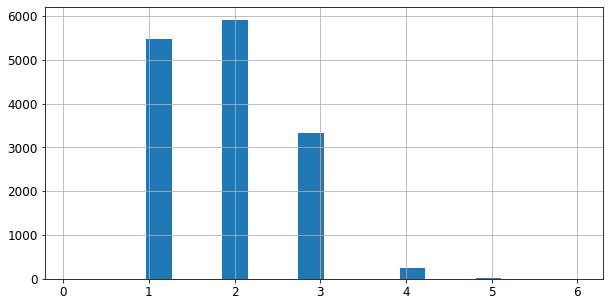

In [42]:
# посмотрим распределение
combined_data['Rooms'].hist(bins=20, figsize=(10, 5))
plt.show()

#### 3.2 Square

In [43]:
combined_data["Square"].describe()

count    15000.000000
mean        56.360546
std         20.423899
min          1.136859
25%         41.814370
50%         52.645758
75%         66.036606
max        641.065186
Name: Square, dtype: float64

посмотрим на квартиры с минимальной площадью (взяла 20 м)

In [44]:
combined_data.loc[combined_data['Square'] < 20].nsmallest(20, 'Square')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,dataset
6392,14786,1,1.000000,1.136859,4.525736,1.0,3,1,1977,0.007122,...,B,1,264,0,NaN,0,1,B,181434.828125,0
10066,9011,53,1.000000,1.378543,1.353573,1.0,1,1,1977,0.049637,...,B,34,7759,0,229.0,1,3,B,NaN,1
14902,1420,45,1.000000,1.975769,2.900371,1.0,1,1,1977,0.195781,...,B,23,5212,6,NaN,3,2,B,NaN,1
8283,15744,34,1.000000,1.988943,2.642219,1.0,21,4,1977,0.069753,...,B,53,13670,4,NaN,1,11,B,458378.781250,0
14490,1165,27,1.000000,2.372101,1.899119,1.0,2,17,1977,0.011654,...,B,4,915,0,NaN,0,0,B,NaN,1
4853,3224,27,0.079944,2.377248,0.873147,0.0,1,0,1977,0.017647,...,B,2,469,0,NaN,0,0,B,126596.945312,0
1608,10202,6,1.000000,2.596351,4.604943,1.0,3,25,2014,0.243205,...,B,5,1564,0,540.0,0,0,B,137597.593750,0
10608,16401,30,1.000000,2.645046,4.338756,1.0,2,1,1977,0.000078,...,B,22,6398,141,1046.0,3,23,B,NaN,1
14713,170,6,2.000000,2.900586,61.468563,1.0,18,17,2014,0.243205,...,B,5,1564,0,540.0,0,0,B,NaN,1
9294,6782,45,1.000000,2.954309,5.257278,1.0,3,1,1977,0.195781,...,B,23,5212,6,NaN,3,2,B,438005.187500,0


откорректируем площадь, используя полученное выше среднее значение

In [45]:
combined_data.loc[combined_data['Square'] < 20, 'Square'] = combined_data["Rooms"]*room_square_median

In [46]:
# проверим
combined_data.loc[combined_data['Square'] < 20].nsmallest(20, 'Square')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,dataset
4853,3224,27,0.079944,2.377248,0.873147,0.0,1,0,1977,0.017647,...,B,2,469,0,NaN,0,0,B,126596.945312,0


In [47]:
combined_data[combined_data['Rooms'] < 1]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,dataset
4853,3224,27,0.079944,2.377248,0.873147,0.0,1,0,1977,0.017647,...,B,2,469,0,NaN,0,0,B,126596.945312,0


In [48]:
# заменим число комнат на 1 и площадь на среднюю
combined_data.loc[combined_data['Rooms'] < 1, 'Rooms'] = 1

In [49]:
combined_data.loc[combined_data['Square'] < 20, 'Square'] = combined_data["Rooms"]*room_square_median

In [50]:
# проверим
combined_data[combined_data['Rooms'] < 1]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,dataset


посмотрим на квартиры с максимальной площадью (взяла более 200 м)

In [51]:
combined_data.loc[combined_data['Square'] > 200].nlargest(20, 'Square')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,dataset
6977,11602,30,2.0,641.065186,638.163208,10.0,20,19,2019,0.000078,...,B,22,6398,141,1046.0,3,23,B,133529.687500,0
4262,28,9,2.0,604.705994,NaN,1.0,17,18,1977,0.161532,...,B,25,5648,1,30.0,2,4,B,187717.250000,0
4690,2307,102,1.0,409.425171,410.639740,10.0,4,4,2016,0.238617,...,B,26,3889,6,705.0,3,6,B,90470.429688,0
1982,5548,86,5.0,275.645294,233.949310,26.0,12,37,2011,0.161976,...,A,31,7010,5,4508.0,3,7,B,455264.875000,0
13217,4058,27,6.0,223.453690,104.113556,16.0,2,2,2017,0.041116,...,B,53,14892,4,NaN,1,4,B,NaN,1
13909,1397,76,3.0,221.138763,118.055344,4.0,32,48,2011,0.000000,...,B,7,1660,39,1786.0,1,5,B,NaN,1
1981,7917,27,1.0,212.932358,211.231125,0.0,2,3,2008,0.211401,...,B,9,1892,0,NaN,0,1,B,302211.250000,0
9910,16568,27,4.0,200.334534,201.627365,25.0,1,2,2013,0.041116,...,B,53,14892,4,NaN,1,4,B,528560.500000,0


Явно видно, что у квартиры с 6 комнатами все верно. У остальных заменим на среднюю

In [52]:
indexes = combined_data[combined_data["Square"] > 200].index
indexes

Int64Index([1981, 1982, 4262, 4690, 6977, 9910, 13217, 13909], dtype='int64')

In [53]:
list = combined_data.loc[(combined_data["Square"] > 200) & (combined_data["Rooms"] != 6)]["Square"]
list

1981     212.932358
1982     275.645294
4262     604.705994
4690     409.425171
6977     641.065186
9910     200.334534
13909    221.138763
Name: Square, dtype: float32

In [54]:
combined_data.loc[(combined_data["Square"] > 200) & (combined_data["Rooms"] != 6), 'Square'] = combined_data["Rooms"]*room_square_median

In [55]:
# проверим
combined_data.loc[combined_data['Square'] > 200].nlargest(20, 'Square')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,dataset
13217,4058,27,6.0,223.45369,104.113556,16.0,2,2,2017,0.041116,...,B,53,14892,4,NaN,1,4,B,NaN,1


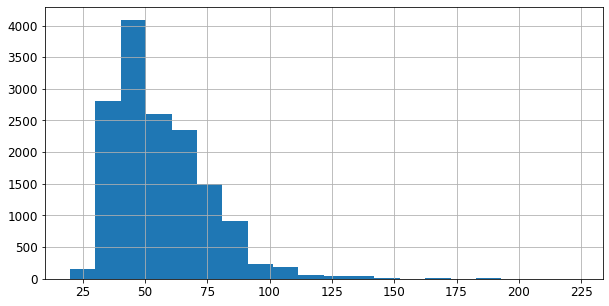

In [56]:
# посмотрим распределение
combined_data['Square'].hist(bins=20, figsize=(10, 5))
plt.show()

Рассмотрим правый хвост подробнее

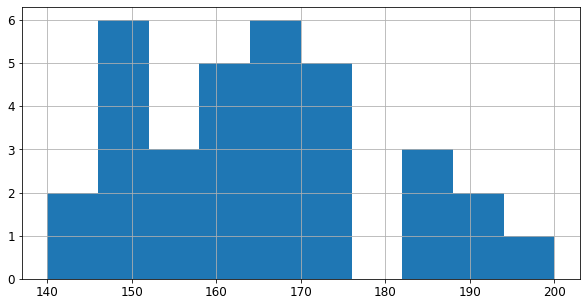

In [57]:
combined_data['Square'].hist(bins=10, range = (140, 200), figsize=(10, 5))
plt.show()

посмотрим на квартиры с площадью 180-200

In [58]:
combined_data.loc[(combined_data['Square'] < 200) & (combined_data['Square'] >180)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,dataset
652,3718,56,3.0,190.857681,107.376167,19.0,7,3,2007,0.000000,...,B,23,5067,4,NaN,2,6,B,338644.06250,0
4487,13434,13,5.0,183.382278,100.985504,15.0,2,6,1997,0.090799,...,B,74,19083,2,NaN,5,15,B,622888.81250,0
5087,15947,129,4.0,185.906403,84.830078,31.0,5,3,2015,0.020741,...,B,24,5613,5,1340.0,2,5,B,340273.25000,0
7201,3233,129,4.0,186.692596,87.487083,32.0,3,3,2011,0.020741,...,B,24,5613,5,1340.0,2,5,B,423443.46875,0
8511,4249,23,5.0,198.930176,123.139862,10.0,1,2,2011,0.014073,...,B,2,475,0,NaN,0,0,B,345665.21875,0
11499,7769,124,4.0,189.679581,114.708672,4.0,19,40,2013,0.174739,...,B,17,3379,9,100.0,0,3,B,NaN,1


Очевидно, что с ними все "хорошо"

#### 3.3 LifeSquare

In [59]:
combined_data["LifeSquare"].describe()

count    11846.000000
mean        36.851711
std         71.120201
min          0.333490
25%         22.896130
50%         32.822811
75%         45.144627
max       7480.592285
Name: LifeSquare, dtype: float64

Рассмотрим квартиры, у которых общая площадь меньше жилой

In [60]:
combined_data.loc[combined_data["Square"] <= combined_data["LifeSquare"]]


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,dataset
28,8054,23,1.0,42.530045,43.967758,1.0,3,9,2014,0.034656,...,B,0,168,0,NaN,0,0,B,95338.195312,0
44,10521,38,3.0,104.211395,106.340401,0.0,20,0,2017,0.060753,...,B,15,2787,2,520.0,0,7,B,435462.062500,0
52,2301,1,2.0,61.400055,65.224602,0.0,17,22,2016,0.007122,...,B,1,264,0,NaN,0,1,B,199215.453125,0
123,8753,25,3.0,85.952309,89.803749,1.0,4,3,2017,0.069753,...,B,53,13670,4,NaN,1,11,B,309688.593750,0
153,9870,62,1.0,51.831474,53.491302,1.0,5,1,2015,0.072158,...,B,2,629,1,NaN,0,0,A,131797.468750,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14927,14686,1,3.0,77.229889,79.958687,1.0,18,17,1977,0.007122,...,B,1,264,0,NaN,0,1,B,NaN,1
14951,3711,94,1.0,41.281055,42.392593,10.0,13,13,2014,0.282798,...,B,33,8667,2,NaN,0,6,B,NaN,1
14962,5820,94,1.0,33.680382,34.198978,1.0,10,9,1972,0.127376,...,B,43,8429,3,NaN,3,9,B,NaN,1
14969,4821,74,2.0,82.542503,82.585068,0.0,4,17,2015,0.309479,...,B,35,7715,4,990.0,0,6,B,NaN,1


проверим, если в LifeSquare нулевые значения

In [61]:
combined_data[combined_data['LifeSquare'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,dataset


заменим значения в "проблемных" квартирах на среднюю долю (жилая к нежилой)

In [62]:
indexes = combined_data.loc[combined_data["Square"] <= combined_data["LifeSquare"]]["Square"].index
indexes

Int64Index([   28,    44,    52,   123,   153,   178,   184,   212,   217,
              234,
            ...
            14713, 14733, 14762, 14779, 14814, 14927, 14951, 14962, 14969,
            14974],
           dtype='int64', length=713)

создадим новый датасет без пропусков в LifeSquare и посчитаем среднюю долю

In [63]:
new2_combined_data = combined_data[combined_data["LifeSquare"].notnull()]

In [64]:
new2_combined_data["LifeSquare"].median() / new2_combined_data["Square"].median()

0.6445888283894372

заменим в проблемных квартирах LifeSquare на среднюю долю

In [65]:
combined_data.loc[combined_data["Square"] <= combined_data["LifeSquare"], 'LifeSquare'] = combined_data["Square"]*0.6446

In [66]:
# проверим
indexes = combined_data.loc[combined_data["Square"] <= combined_data["LifeSquare"]]["Square"].index
indexes

Int64Index([], dtype='int64')

замена прошла

посмотрим, есть ли квартиры с маленькой жилой площадью (меньше 10)

In [67]:
combined_data[combined_data['LifeSquare'] < 10]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,dataset
26,4378,27,3.0,106.958870,0.641822,0.0,17,0,2018,0.072158,...,B,2,629,1,NaN,0,0,A,337299.875000,0
95,4280,34,2.0,61.334969,4.091945,1.0,26,1,2014,0.069753,...,B,53,13670,4,NaN,1,11,B,286564.437500,0
134,12613,6,2.0,65.496674,5.589324,1.0,5,17,1977,0.243205,...,B,5,1564,0,540.0,0,0,B,180727.640625,0
158,16779,27,3.0,51.991066,4.896202,1.0,22,25,1977,0.072158,...,B,2,629,1,NaN,0,0,A,174687.562500,0
160,3522,6,1.0,66.419838,3.987101,1.0,2,1,1977,0.243205,...,B,5,1564,0,540.0,0,0,B,193361.234375,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14818,8963,27,3.0,79.114388,3.329216,1.0,3,22,1977,0.211401,...,B,9,1892,0,NaN,0,1,B,NaN,1
14846,5002,1,3.0,82.624840,4.379317,1.0,5,17,2016,0.007122,...,B,1,264,0,NaN,0,1,B,NaN,1
14863,4611,27,2.0,76.709541,2.989508,1.0,13,12,2016,0.072158,...,B,2,629,1,NaN,0,0,A,NaN,1
14902,1420,45,1.0,29.736467,2.900371,1.0,1,1,1977,0.195781,...,B,23,5212,6,NaN,3,2,B,NaN,1


Заменим их на среднюю долю

In [68]:
combined_data.loc[combined_data["LifeSquare"] < 10, 'LifeSquare'] = combined_data["Square"]*0.6446

In [69]:
# проверим
combined_data[combined_data['LifeSquare'] < 10]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,dataset


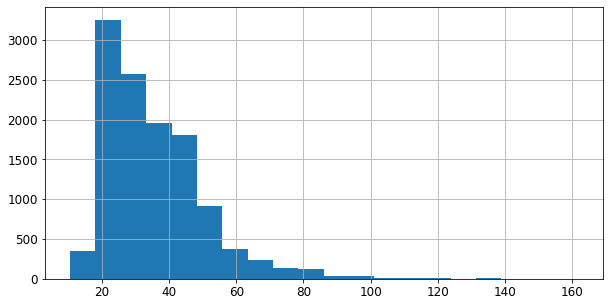

In [70]:
# посмотрим распределение
combined_data['LifeSquare'].hist(bins=20, figsize=(10, 5))
plt.show()

Рассмотрим правый хвост подробнее

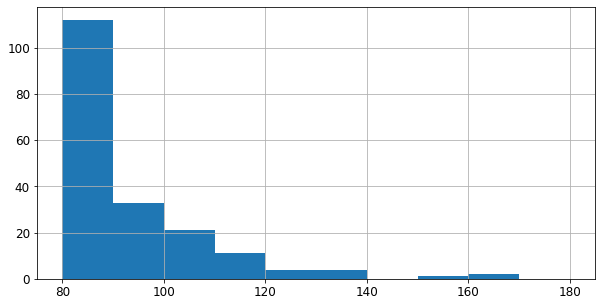

In [71]:
combined_data['LifeSquare'].hist(bins=10, range = (80, 180), figsize=(10, 5))
plt.show()

еще подробнее

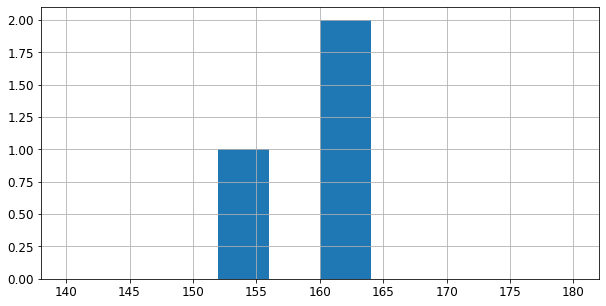

In [72]:
combined_data['LifeSquare'].hist(bins=10, range = (140, 180), figsize=(10, 5))
plt.show()

посмотрим, что это за квартиры

In [73]:
combined_data.loc[(combined_data['LifeSquare'] < 165) & (combined_data['LifeSquare'] >150)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,dataset
2603,5621,23,3.0,163.495331,161.504227,12.0,5,3,1977,0.014073,...,B,2,475,0,NaN,0,0,B,207007.953125,0
4047,15362,23,1.0,163.286972,161.155273,1.0,4,3,1977,0.014073,...,B,2,475,0,NaN,0,0,B,228572.515625,0
5444,14181,62,3.0,156.636581,153.685837,1.0,1,3,2005,0.072158,...,B,2,629,1,NaN,0,0,A,502523.562500,0


если не сильно придираться, то вполне адекватно

#### 3.4  KitchenSquare

In [74]:
combined_data["KitchenSquare"].describe()

count    15000.000000
mean         6.174467
std         24.017548
min          0.000000
25%          1.000000
50%          6.000000
75%          9.000000
max       2014.000000
Name: KitchenSquare, dtype: float64

посмотрим на кухни с площадью меньше 5, но не равную нулю (например, это студии или кухня совмещена с гостиной)

In [75]:
combined_data.loc[(combined_data['KitchenSquare'] < 5) & (combined_data['KitchenSquare'] != 0)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,dataset
8,5172,1,2.0,64.511436,NaN,1.0,9,17,1977,0.007122,...,B,1,264,0,NaN,0,1,B,229102.796875,0
12,6452,13,2.0,54.522804,31.759752,1.0,8,12,1999,0.090799,...,B,74,19083,2,NaN,5,15,B,229220.375000,0
14,10953,27,1.0,53.769096,52.408028,1.0,5,4,1977,0.072158,...,B,2,629,1,NaN,0,0,A,140647.562500,0
21,11935,27,2.0,64.711838,NaN,1.0,15,1,1977,0.211401,...,B,9,1892,0,NaN,0,1,B,127200.023438,0
25,5073,74,2.0,82.667915,NaN,1.0,16,17,1977,0.075779,...,B,6,1437,3,NaN,0,2,B,244145.828125,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14972,16064,30,1.0,38.376236,37.003311,1.0,2,1,1977,0.000078,...,B,22,6398,141,1046.0,3,23,B,NaN,1
14982,12920,23,1.0,39.610428,38.187572,1.0,6,18,2013,0.034656,...,B,0,168,0,NaN,0,0,B,NaN,1
14985,11732,1,1.0,46.597282,NaN,1.0,17,24,1977,0.007122,...,B,1,264,0,NaN,0,1,B,NaN,1
14987,5361,53,3.0,80.102104,NaN,1.0,13,22,1977,0.049637,...,B,34,7759,0,229.0,1,3,B,NaN,1


получается, что пятая часть квартир имеет кухню менее 5 метров

посмотрим, сколько квартир с кухней 1м

In [76]:
combined_data.loc[combined_data['KitchenSquare'] == 1]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,dataset
8,5172,1,2.0,64.511436,NaN,1.0,9,17,1977,0.007122,...,B,1,264,0,NaN,0,1,B,229102.796875,0
12,6452,13,2.0,54.522804,31.759752,1.0,8,12,1999,0.090799,...,B,74,19083,2,NaN,5,15,B,229220.375000,0
14,10953,27,1.0,53.769096,52.408028,1.0,5,4,1977,0.072158,...,B,2,629,1,NaN,0,0,A,140647.562500,0
21,11935,27,2.0,64.711838,NaN,1.0,15,1,1977,0.211401,...,B,9,1892,0,NaN,0,1,B,127200.023438,0
25,5073,74,2.0,82.667915,NaN,1.0,16,17,1977,0.075779,...,B,6,1437,3,NaN,0,2,B,244145.828125,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14972,16064,30,1.0,38.376236,37.003311,1.0,2,1,1977,0.000078,...,B,22,6398,141,1046.0,3,23,B,NaN,1
14982,12920,23,1.0,39.610428,38.187572,1.0,6,18,2013,0.034656,...,B,0,168,0,NaN,0,0,B,NaN,1
14985,11732,1,1.0,46.597282,NaN,1.0,17,24,1977,0.007122,...,B,1,264,0,NaN,0,1,B,NaN,1
14987,5361,53,3.0,80.102104,NaN,1.0,13,22,1977,0.049637,...,B,34,7759,0,229.0,1,3,B,NaN,1


Посмотрим сколько квартир с кухней больше 30 м (вдруг они кухню-гостинную считали как кухня)

In [77]:
combined_data[combined_data['KitchenSquare'] > 30]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,dataset
227,16395,2,3.0,79.722244,44.731220,72.0,12,16,1987,0.130618,...,B,39,10418,9,900.0,1,9,B,370148.625000,0
551,1315,6,1.0,48.128113,45.023533,48.0,21,1,2013,0.243205,...,B,5,1564,0,540.0,0,0,B,146950.906250,0
1064,14656,62,1.0,47.100719,46.447960,2014.0,4,1,2014,0.072158,...,B,2,629,1,NaN,0,0,A,108337.484375,0
1077,9690,27,1.0,40.081043,37.834965,37.0,18,19,2019,0.211401,...,B,9,1892,0,NaN,0,1,B,93218.648438,0
1369,2371,27,2.0,68.841072,64.234955,66.0,4,2,2014,0.017647,...,B,2,469,0,NaN,0,0,B,189244.250000,0
1455,12507,54,2.0,79.810532,79.578964,78.0,10,15,2014,0.006076,...,B,30,5285,0,645.0,6,6,B,438708.718750,0
1860,4265,161,2.0,53.216778,32.644859,53.0,7,17,1994,0.000699,...,B,14,3369,24,4129.0,0,3,B,261125.671875,0
1867,3267,58,3.0,138.980820,138.004593,43.0,2,2,1977,0.437885,...,B,23,5735,3,1084.0,0,5,B,169528.890625,0
2916,12390,72,3.0,97.490677,62.842491,96.0,22,25,2019,0.210473,...,B,11,2398,2,1994.0,3,0,B,445074.968750,0
2969,7441,62,3.0,114.734474,112.589081,112.0,3,3,2015,0.072158,...,B,2,629,1,NaN,0,0,A,315245.531250,0


Видим, что есть кухни с ОЧЕНЬ большой площадью. рассмотрим те, которые больше 100

In [78]:
combined_data[combined_data['KitchenSquare'] > 50]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,dataset
227,16395,2,3.0,79.722244,44.731220,72.0,12,16,1987,0.130618,...,B,39,10418,9,900.0,1,9,B,370148.625000,0
1064,14656,62,1.0,47.100719,46.447960,2014.0,4,1,2014,0.072158,...,B,2,629,1,NaN,0,0,A,108337.484375,0
1369,2371,27,2.0,68.841072,64.234955,66.0,4,2,2014,0.017647,...,B,2,469,0,NaN,0,0,B,189244.250000,0
1455,12507,54,2.0,79.810532,79.578964,78.0,10,15,2014,0.006076,...,B,30,5285,0,645.0,6,6,B,438708.718750,0
1860,4265,161,2.0,53.216778,32.644859,53.0,7,17,1994,0.000699,...,B,14,3369,24,4129.0,0,3,B,261125.671875,0
2916,12390,72,3.0,97.490677,62.842491,96.0,22,25,2019,0.210473,...,B,11,2398,2,1994.0,3,0,B,445074.968750,0
2969,7441,62,3.0,114.734474,112.589081,112.0,3,3,2015,0.072158,...,B,2,629,1,NaN,0,0,A,315245.531250,0
4079,6508,23,2.0,67.146049,33.959152,63.0,5,17,2019,0.034656,...,B,0,168,0,NaN,0,0,B,193130.578125,0
4110,299,27,2.0,66.787521,64.616661,60.0,14,20,2015,0.017647,...,B,2,469,0,NaN,0,0,B,179466.093750,0
4651,12552,58,3.0,116.405693,113.109650,112.0,3,3,2016,0.437885,...,B,23,5735,3,1084.0,0,5,B,296165.937500,0


заменим эти площади на среднюю долю (к общей площади)

In [79]:
new3_combined_data = combined_data[combined_data["KitchenSquare"].notnull()]

In [80]:
new3_combined_data["KitchenSquare"].median() / new3_combined_data["Square"].median()

0.11391370953070157

In [81]:
combined_data.loc[combined_data["KitchenSquare"] > 50, 'KitchenSquare'] = combined_data["Square"]*0.1139

In [82]:
# проверка
combined_data[combined_data['KitchenSquare'] > 50]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,dataset


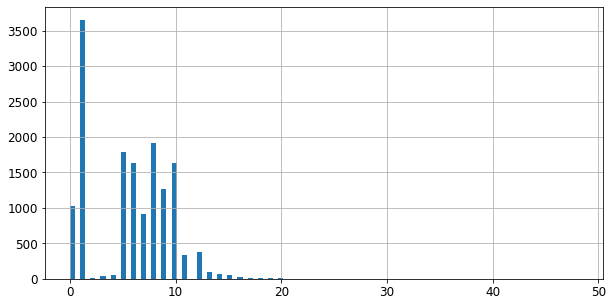

In [83]:
# посмотрим распределение
combined_data['KitchenSquare'].hist(bins=100, figsize=(10, 5))
plt.show()

посмотрим хвост

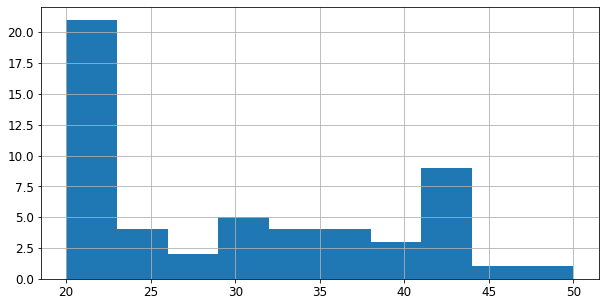

In [84]:
combined_data['KitchenSquare'].hist(bins=10, range = (20, 50), figsize=(10, 5))
plt.show()

вполне адекватно

#### 3.5  Floor

In [85]:
combined_data["Floor"].describe()

count    15000.000000
mean         8.561800
std          5.323113
min          1.000000
25%          4.000000
50%          7.000000
75%         12.000000
max         78.000000
Name: Floor, dtype: float64

посмотрим на квартиры выше 30 этажа

In [86]:
combined_data[combined_data['Floor'] > 30]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,dataset
339,11563,8,1.0,50.390862,41.642899,0.0,32,32,2008,0.092291,...,B,21,4346,2,165.0,1,2,B,97480.843750,0
2781,1674,76,2.0,74.344673,41.044132,5.0,42,48,2016,0.000000,...,B,7,1660,39,1786.0,1,5,B,411691.500000,0
3330,3298,31,1.0,57.551693,21.551876,10.0,32,40,1977,0.151346,...,A,32,5889,10,830.0,4,1,B,393799.531250,0
4323,6589,30,1.0,62.110825,52.812126,4.0,31,44,2009,0.000078,...,B,22,6398,141,1046.0,3,23,B,117647.460938,0
6755,8296,146,1.0,86.386757,71.904999,0.0,37,38,2012,0.236108,...,B,16,3893,27,NaN,3,10,B,269113.593750,0
8357,8016,31,1.0,59.519897,24.050533,10.0,33,40,1977,0.151346,...,A,32,5889,10,830.0,4,1,B,389554.062500,0
11587,5707,76,2.0,73.363525,38.740059,5.0,38,48,2010,0.000000,...,B,7,1660,39,1786.0,1,5,B,NaN,1
13585,4533,31,2.0,83.963303,38.419224,14.0,33,40,2014,0.151346,...,A,32,5889,10,830.0,4,1,B,NaN,1
13711,414,76,2.0,67.609810,41.175949,5.0,46,48,2002,0.000000,...,B,7,1660,39,1786.0,1,5,B,NaN,1
13909,1397,76,3.0,89.209404,57.504383,4.0,32,48,2011,0.000000,...,B,7,1660,39,1786.0,1,5,B,NaN,1


мне не нравится квартира на 78 этаже 22х этажного дома и два дома 1977 года постройки (не уверна, что тогда строили такие высокие дома). заменим их средним

In [87]:
combined_data["Floor"].mean()

8.5618

In [88]:
combined_data["Floor"].iloc[14698] = 8

In [89]:
combined_data["Floor"].iloc[8357] = 8

In [90]:
combined_data["Floor"].iloc[3330] = 8

In [91]:
# проверка 
combined_data[combined_data['Floor'] > 30]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,dataset
339,11563,8,1.0,50.390862,41.642899,0.0,32,32,2008,0.092291,...,B,21,4346,2,165.0,1,2,B,97480.843750,0
2781,1674,76,2.0,74.344673,41.044132,5.0,42,48,2016,0.000000,...,B,7,1660,39,1786.0,1,5,B,411691.500000,0
4323,6589,30,1.0,62.110825,52.812126,4.0,31,44,2009,0.000078,...,B,22,6398,141,1046.0,3,23,B,117647.460938,0
6755,8296,146,1.0,86.386757,71.904999,0.0,37,38,2012,0.236108,...,B,16,3893,27,NaN,3,10,B,269113.593750,0
11587,5707,76,2.0,73.363525,38.740059,5.0,38,48,2010,0.000000,...,B,7,1660,39,1786.0,1,5,B,NaN,1
13585,4533,31,2.0,83.963303,38.419224,14.0,33,40,2014,0.151346,...,A,32,5889,10,830.0,4,1,B,NaN,1
13711,414,76,2.0,67.609810,41.175949,5.0,46,48,2002,0.000000,...,B,7,1660,39,1786.0,1,5,B,NaN,1
13909,1397,76,3.0,89.209404,57.504383,4.0,32,48,2011,0.000000,...,B,7,1660,39,1786.0,1,5,B,NaN,1
14192,13970,8,1.0,49.806976,45.910824,1.0,32,32,2009,0.092291,...,B,21,4346,2,165.0,1,2,B,NaN,1
14549,16166,31,2.0,88.186012,54.253582,16.0,31,40,2012,0.151346,...,A,32,5889,10,830.0,4,1,B,NaN,1


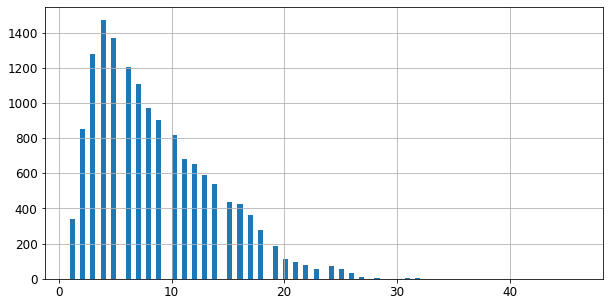

In [92]:
# посмотрим распределение
combined_data['Floor'].hist(bins=100, figsize=(10, 5))
plt.show()

посмотрим хвост

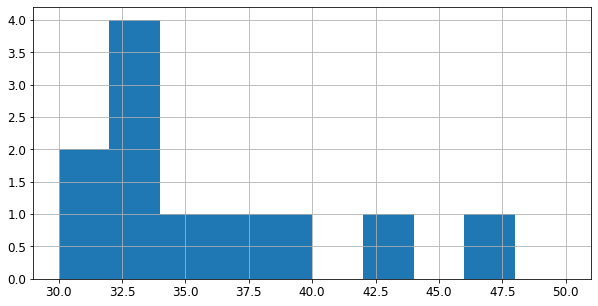

In [93]:
combined_data['Floor'].hist(bins=10, range = (30, 50), figsize=(10, 5))
plt.show()

вполне адекватно

#### 3.6 HouseFloor

In [94]:
combined_data["HouseFloor"].describe()

count    15000.000000
mean        12.606600
std          6.780165
min          0.000000
25%          9.000000
50%         12.000000
75%         17.000000
max        117.000000
Name: HouseFloor, dtype: float64

посмотрим дома выше 40

In [95]:
combined_data[combined_data["HouseFloor"] > 40]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,dataset
540,5279,93,2.0,60.804543,30.923826,11.0,5,45,2016,0.050900,...,B,43,10621,1,30.0,2,3,B,213171.140625,0
2781,1674,76,2.0,74.344673,41.044132,5.0,42,48,2016,0.000000,...,B,7,1660,39,1786.0,1,5,B,411691.500000,0
3974,6502,20,1.0,126.389519,103.637321,14.0,22,47,2012,0.019509,...,B,37,7687,11,176.0,5,5,B,450706.562500,0
4323,6589,30,1.0,62.110825,52.812126,4.0,31,44,2009,0.000078,...,B,22,6398,141,1046.0,3,23,B,117647.460938,0
6131,10806,5,1.0,51.944588,48.709602,1.0,6,99,1977,0.150818,...,B,16,3433,4,2643.0,4,5,B,296127.125000,0
7728,7453,24,3.0,126.621361,62.455482,12.0,22,48,2011,0.111627,...,B,50,12238,8,1970.0,2,3,B,179396.515625,0
8599,9300,74,2.0,71.747871,46.248676,9.0,5,99,1977,0.075779,...,B,6,1437,3,NaN,0,2,B,243329.906250,0
8854,78,30,2.0,65.773750,42.397758,1.0,8,117,1977,0.000078,...,B,22,6398,141,1046.0,3,23,B,207248.375000,0
10651,15864,27,3.0,47.722836,47.098812,9.0,18,99,1977,0.072158,...,B,2,629,1,NaN,0,0,A,NaN,1
11587,5707,76,2.0,73.363525,38.740059,5.0,38,48,2010,0.000000,...,B,7,1660,39,1786.0,1,5,B,NaN,1


смущают дома 1977 года. Заменю этажность на этаж квартиры

In [96]:
combined_data["HouseFloor"].iloc[6131] = 6

In [97]:
combined_data["HouseFloor"].iloc[8599] = 5

In [98]:
combined_data["HouseFloor"].iloc[8854] = 8

In [99]:
combined_data["HouseFloor"].iloc[10651] = 18

In [100]:
# проверка
combined_data[combined_data["HouseFloor"] > 40]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,dataset
540,5279,93,2.0,60.804543,30.923826,11.0,5,45,2016,0.050900,...,B,43,10621,1,30.0,2,3,B,213171.140625,0
2781,1674,76,2.0,74.344673,41.044132,5.0,42,48,2016,0.000000,...,B,7,1660,39,1786.0,1,5,B,411691.500000,0
3974,6502,20,1.0,126.389519,103.637321,14.0,22,47,2012,0.019509,...,B,37,7687,11,176.0,5,5,B,450706.562500,0
4323,6589,30,1.0,62.110825,52.812126,4.0,31,44,2009,0.000078,...,B,22,6398,141,1046.0,3,23,B,117647.460938,0
7728,7453,24,3.0,126.621361,62.455482,12.0,22,48,2011,0.111627,...,B,50,12238,8,1970.0,2,3,B,179396.515625,0
11587,5707,76,2.0,73.363525,38.740059,5.0,38,48,2010,0.000000,...,B,7,1660,39,1786.0,1,5,B,NaN,1
13711,414,76,2.0,67.609810,41.175949,5.0,46,48,2002,0.000000,...,B,7,1660,39,1786.0,1,5,B,NaN,1
13909,1397,76,3.0,89.209404,57.504383,4.0,32,48,2011,0.000000,...,B,7,1660,39,1786.0,1,5,B,NaN,1


посмотрим дома с 0 этажами и замним их на этаж квартиры

In [101]:
combined_data[combined_data["HouseFloor"] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,dataset
7,11993,74,2.0,80.312927,NaN,0.0,14,0,1977,0.075779,...,B,6,1437,3,NaN,0,2,B,221244.15625,0
23,6641,54,3.0,118.907608,NaN,0.0,2,0,1977,0.006076,...,B,30,5285,0,645.0,6,6,B,571069.06250,0
26,4378,27,3.0,106.958870,68.945686,0.0,17,0,2018,0.072158,...,B,2,629,1,NaN,0,0,A,337299.87500,0
39,9371,23,2.0,60.503250,NaN,0.0,16,0,1977,0.034656,...,B,0,168,0,NaN,0,0,B,229778.06250,0
44,10521,38,3.0,104.211395,67.174667,0.0,20,0,2017,0.060753,...,B,15,2787,2,520.0,0,7,B,435462.06250,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14856,10262,27,2.0,69.196442,NaN,0.0,10,0,1977,0.017647,...,B,2,469,0,NaN,0,0,B,NaN,1
14887,12116,88,3.0,89.549561,NaN,0.0,20,0,1977,0.127376,...,B,43,8429,3,NaN,3,9,B,NaN,1
14892,16357,58,1.0,49.205978,NaN,0.0,4,0,1977,0.437885,...,B,23,5735,3,1084.0,0,5,B,NaN,1
14976,4723,95,1.0,45.542938,NaN,0.0,6,0,1977,0.000699,...,B,14,3369,24,4129.0,0,3,B,NaN,1


In [102]:
combined_data.loc[combined_data["HouseFloor"] == 0, 'HouseFloor'] = combined_data["Floor"]

In [103]:
# проверка
combined_data[combined_data["HouseFloor"] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,dataset


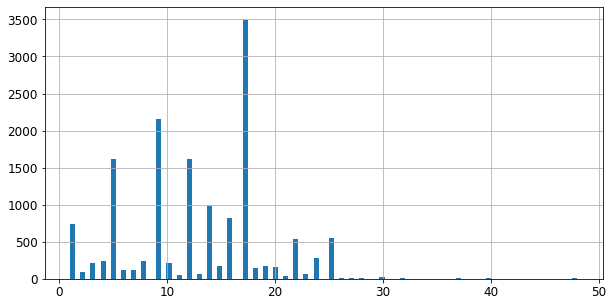

In [104]:
# посмотрим распределение
combined_data['HouseFloor'].hist(bins=100, figsize=(10, 5))
plt.show()

посмотрим хвост

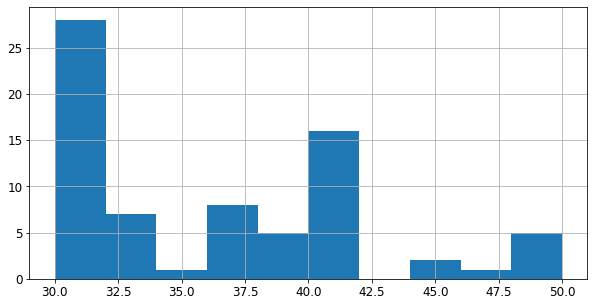

In [105]:
combined_data['HouseFloor'].hist(bins=10, range = (30, 50), figsize=(10, 5))
plt.show()

вполне адекватно

#### 3.6 HouseYear

In [106]:
combined_data["HouseYear"].describe()

count    1.500000e+04
mean     3.321575e+03
std      1.637078e+05
min      1.908000e+03
25%      1.974000e+03
50%      1.977000e+03
75%      2.001000e+03
max      2.005201e+07
Name: HouseYear, dtype: float64

исследуем старые дома (довоенной постройки)

In [107]:
combined_data[combined_data["HouseYear"] < 1945]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,dataset
196,5198,7,3.0,91.904015,62.839714,7.0,6,5,1937,0.130618,...,B,39,10418,9,900.0,1,9,B,309690.968750,0
505,7755,126,4.0,79.142365,55.242146,7.0,5,7,1938,0.333892,...,B,30,6564,1,NaN,0,0,B,273213.562500,0
837,14261,174,3.0,65.812759,48.988728,6.0,5,7,1935,0.000078,...,B,22,6398,141,1046.0,3,23,B,421851.968750,0
910,6751,172,2.0,56.172363,28.384212,7.0,8,6,1914,0.000000,...,B,7,1660,39,1786.0,1,5,B,423580.468750,0
1029,13234,157,1.0,28.145334,17.650400,4.0,4,5,1932,0.000000,...,B,30,7538,87,4702.0,5,5,B,201311.765625,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13893,3859,173,3.0,77.041260,55.996666,7.0,6,5,1932,0.081943,...,B,20,2738,20,NaN,1,4,B,NaN,1
14159,9111,196,3.0,75.567062,50.680550,9.0,5,4,1927,0.000000,...,B,30,7538,87,4702.0,5,5,B,NaN,1
14367,5461,155,4.0,86.955956,63.159809,6.0,4,6,1938,0.042307,...,B,17,2810,9,4849.0,3,6,B,NaN,1
14756,10352,73,3.0,68.970558,46.823891,7.0,5,5,1928,0.042032,...,B,37,6856,84,1940.0,2,5,B,NaN,1


данные логичные

рассмотрим современные дома

In [108]:
combined_data[combined_data["HouseYear"] > 2020]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,dataset
1497,10814,109,1.0,37.265072,20.239714,9.0,9,12,20052011,0.136330,...,B,30,6141,10,262.0,3,6,B,254084.531250,0
4189,11607,147,2.0,44.791836,28.360394,5.0,4,9,4968,0.319809,...,B,25,4756,16,2857.0,5,8,B,243028.609375,0


явная ошибка. исправим на 2005 на 1968 соответственно

In [109]:
combined_data["HouseYear"].iloc[1497] = 2005

In [110]:
combined_data["HouseYear"].iloc[4189] = 1968

In [111]:
# проверка
combined_data[combined_data["HouseYear"] > 2020]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,dataset


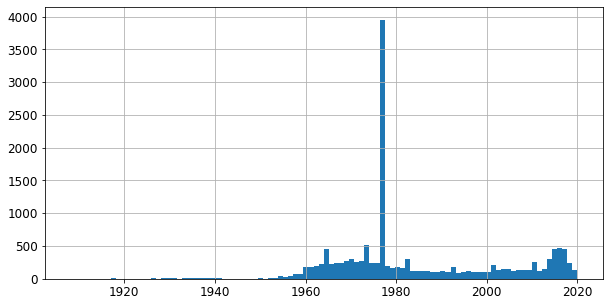

In [112]:
# посмотрим распределение
combined_data['HouseYear'].hist(bins=100, figsize=(10, 5))
plt.show()

посмотрим на выброс

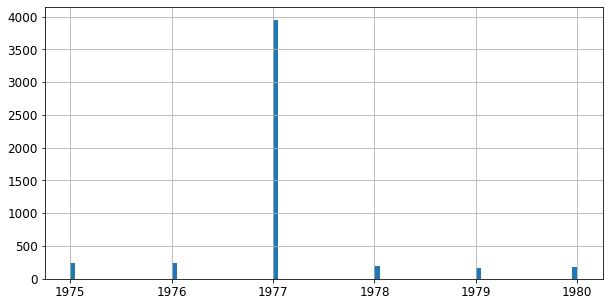

In [113]:
combined_data['HouseYear'].hist(bins=100, range = (1975, 1980), figsize=(10, 5))
plt.show()

посмотрим дома 1977 года постройки

In [114]:
combined_data[combined_data["HouseYear"] == 1977]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,dataset
3,5809,58,2.0,53.352982,52.731510,9.0,8,17,1977,0.437885,...,B,23,5735,3,1084.0,0,5,B,175616.234375,0
7,11993,74,2.0,80.312927,NaN,0.0,14,14,1977,0.075779,...,B,6,1437,3,NaN,0,2,B,221244.156250,0
8,5172,1,2.0,64.511436,NaN,1.0,9,17,1977,0.007122,...,B,1,264,0,NaN,0,1,B,229102.796875,0
14,10953,27,1.0,53.769096,52.408028,1.0,5,4,1977,0.072158,...,B,2,629,1,NaN,0,0,A,140647.562500,0
21,11935,27,2.0,64.711838,NaN,1.0,15,1,1977,0.211401,...,B,9,1892,0,NaN,0,1,B,127200.023438,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14976,4723,95,1.0,45.542938,NaN,0.0,6,6,1977,0.000699,...,B,14,3369,24,4129.0,0,3,B,NaN,1
14985,11732,1,1.0,46.597282,NaN,1.0,17,24,1977,0.007122,...,B,1,264,0,NaN,0,1,B,NaN,1
14987,5361,53,3.0,80.102104,NaN,1.0,13,22,1977,0.049637,...,B,34,7759,0,229.0,1,3,B,NaN,1
14998,4780,62,2.0,81.305222,NaN,0.0,4,4,1977,0.072158,...,B,2,629,1,NaN,0,0,A,NaN,1


Вроде адекватно

#### 3.7 Ecology_1

In [115]:
combined_data["Ecology_1"].describe()

count    15000.000000
mean         0.119195
std          0.119371
min          0.000000
25%          0.017647
50%          0.075424
75%          0.195781
max          0.521867
Name: Ecology_1, dtype: float64

ничего выдающегося

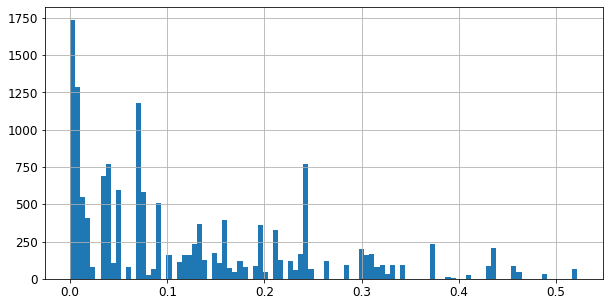

In [116]:
# посмотрим распределение
combined_data['Ecology_1'].hist(bins=100, figsize=(10, 5))
plt.show()

все вполне адекватно

#### 3.8 Ecology_2

In [117]:
combined_data["Ecology_2"].describe()

count     15000
unique        2
top           B
freq      14855
Name: Ecology_2, dtype: object

ничего особенного

#### 3.9 Ecology_3

In [118]:
combined_data["Ecology_3"].describe()

count     15000
unique        2
top           B
freq      14576
Name: Ecology_3, dtype: object

ничего особенного

#### 3.10 Social_1

In [119]:
combined_data["Social_1"].describe()

count    15000.000000
mean        24.769267
std         17.532278
min          0.000000
25%          6.000000
50%         25.000000
75%         36.000000
max         74.000000
Name: Social_1, dtype: float64

ничего особенного

#### 3.11 Social_2

In [120]:
combined_data["Social_2"].describe()

count    15000.000000
mean      5370.404933
std       4013.364403
min        168.000000
25%       1564.000000
50%       5285.000000
75%       7287.000000
max      19083.000000
Name: Social_2, dtype: float64

ничего особенного

#### 3.12 Social_3

In [121]:
combined_data["Social_3"].describe()

count    15000.000000
mean         8.113667
std         23.841946
min          0.000000
25%          0.000000
50%          2.000000
75%          5.000000
max        141.000000
Name: Social_3, dtype: float64

есть нулевые значения, но не с чем скоррелировать. оставляем так

#### 3.13 Healthcare_1

In [122]:
combined_data["Healthcare_1"].describe()

count    7825.000000
mean     1144.162476
std      1029.307373
min         0.000000
25%       350.000000
50%       900.000000
75%      1548.000000
max      4849.000000
Name: Healthcare_1, dtype: float64

есть нулевые значения, но не с чем скоррелировать. оставляем так

#### 3.14 Healthcare_2

In [123]:
combined_data["Helthcare_2"].describe()

count    15000.000000
mean         1.319467
std          1.489012
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          6.000000
Name: Helthcare_2, dtype: float64

есть нулевые значения, но не с чем скоррелировать. оставляем так

#### 3.15 Shops_1

In [124]:
combined_data["Shops_1"].describe()

count    15000.000000
mean         4.235133
std          4.796545
min          0.000000
25%          1.000000
50%          3.000000
75%          6.000000
max         23.000000
Name: Shops_1, dtype: float64

все нормально

#### 3.16 Shops_2

In [125]:
combined_data["Shops_2"].describe()

count     15000
unique        2
top           B
freq      13763
Name: Shops_2, dtype: object

все нормально

### посмотрим пропуски

In [126]:
combined_data["DistrictId"].isna().sum()

0

In [127]:
combined_data["Rooms"].isna().sum()

0

In [128]:
combined_data["Square"].isna().sum()

0

In [129]:
combined_data["LifeSquare"].isna().sum()

3154

In [130]:
combined_data["KitchenSquare"].isna().sum()

0

In [131]:
combined_data["Floor"].isna().sum()

0

In [132]:
combined_data["HouseFloor"].isna().sum()

0

In [133]:
combined_data["HouseYear"].isna().sum()

0

In [134]:
combined_data["Ecology_1"].isna().sum()

0

In [135]:
combined_data["Ecology_2"].isna().sum()

0

In [136]:
combined_data["Ecology_3"].isna().sum()

0

In [137]:
combined_data["Social_1"].isna().sum()

0

In [138]:
combined_data["Social_2"].isna().sum()

0

In [139]:
combined_data["Social_3"].isna().sum()

0

In [140]:
combined_data["Healthcare_1"].isna().sum()

7175

In [141]:
combined_data["Helthcare_2"].isna().sum()

0

In [142]:
combined_data["Shops_1"].isna().sum()

0

In [143]:
combined_data["Shops_2"].isna().sum()

0

У двух признаков есть пропуски. Рассмотрим каждый отдельно.

Заменю в LifeSquare пропуски на медианные значения

In [144]:
combined_data["LifeSquare"].fillna(combined_data["LifeSquare"].median(),inplace=True)

In [145]:
# проверка
combined_data["LifeSquare"].isna().sum()

0

Рассмотрим HealthCare_1. 

In [146]:
combined_data["Healthcare_1"].isna().sum() / combined_data.shape[0]

0.47833333333333333

Пропущенных значений почти половина. Удаляю из датасета, т.к. нет возможности каким либо образом их интерпретировать и заменить

In [147]:
combined_data.drop(columns='Healthcare_1',inplace=True)

In [148]:
combined_data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,dataset
0,14038,35,2.0,47.981560,29.442751,6.0,7,9,1969,0.089040,B,B,33,7976,5,0,11,B,184966.937500,0
1,15053,41,3.0,65.683640,40.049541,8.0,7,9,1978,0.000070,B,B,46,10309,1,1,16,B,300009.437500,0
2,4765,53,2.0,44.947952,29.197611,0.0,8,12,1968,0.049637,B,B,34,7759,0,1,3,B,220925.906250,0
3,5809,58,2.0,53.352982,52.731510,9.0,8,17,1977,0.437885,B,B,23,5735,3,0,5,B,175616.234375,0
4,10783,99,1.0,39.649193,23.776169,7.0,11,12,1976,0.012339,B,B,35,5776,1,2,4,B,150226.531250,0


### Неинформативные признаки
Если признак имеет слишком много строк с одинаковыми значениями, он не несет полезной информации для проекта.

In [149]:
num_rows = len(combined_data.index)
low_information_cols = [] 

for col in combined_data.columns:
    cnts = combined_data[col].value_counts(dropna=False)
    top_pct = (cnts/num_rows).iloc[0]
    
    if top_pct > 0.95:
        low_information_cols.append(col)
        print('{0}: {1:.5f}%'.format(col, top_pct*100))
        print(cnts)
        print()

Ecology_2: 99.03333%
B    14855
A      145
Name: Ecology_2, dtype: int64

Ecology_3: 97.17333%
B    14576
A      424
Name: Ecology_3, dtype: int64



Удалю эти признаки

In [150]:
combined_data.drop(columns='Ecology_2',inplace=True)
combined_data.drop(columns='Ecology_3',inplace=True)

In [151]:
combined_data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,dataset
0,14038,35,2.0,47.981560,29.442751,6.0,7,9,1969,0.089040,33,7976,5,0,11,B,184966.937500,0
1,15053,41,3.0,65.683640,40.049541,8.0,7,9,1978,0.000070,46,10309,1,1,16,B,300009.437500,0
2,4765,53,2.0,44.947952,29.197611,0.0,8,12,1968,0.049637,34,7759,0,1,3,B,220925.906250,0
3,5809,58,2.0,53.352982,52.731510,9.0,8,17,1977,0.437885,23,5735,3,0,5,B,175616.234375,0
4,10783,99,1.0,39.649193,23.776169,7.0,11,12,1976,0.012339,35,5776,1,2,4,B,150226.531250,0


#### Посмотрим зависимости между признаками 

In [152]:
cd_new = combined_data

<AxesSubplot:xlabel='DistrictId', ylabel='Price'>

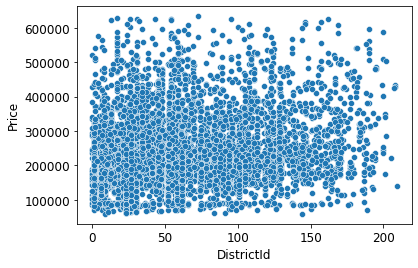

In [153]:
sns.scatterplot(cd_new.DistrictId, cd_new.Price)

<AxesSubplot:xlabel='Rooms', ylabel='Price'>

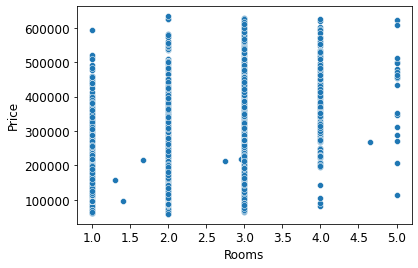

In [154]:
sns.scatterplot(cd_new.Rooms, cd_new.Price)

<AxesSubplot:xlabel='Square', ylabel='Price'>

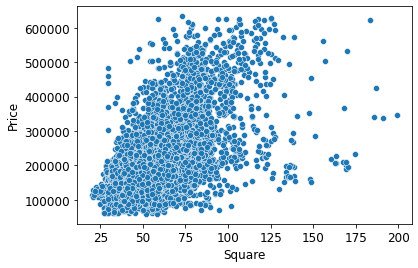

In [155]:
sns.scatterplot(cd_new.Square, cd_new.Price)

<AxesSubplot:xlabel='LifeSquare', ylabel='Price'>

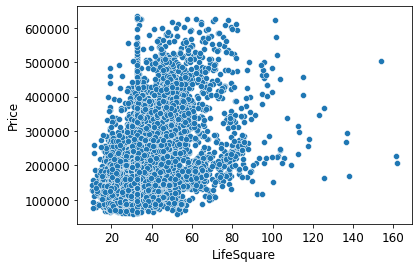

In [156]:
sns.scatterplot(cd_new.LifeSquare, cd_new.Price)

<AxesSubplot:xlabel='KitchenSquare', ylabel='Price'>

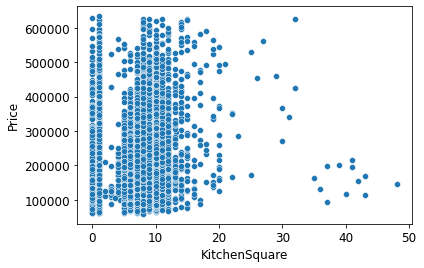

In [157]:
sns.scatterplot(cd_new.KitchenSquare, cd_new.Price)

<AxesSubplot:xlabel='Floor', ylabel='Price'>

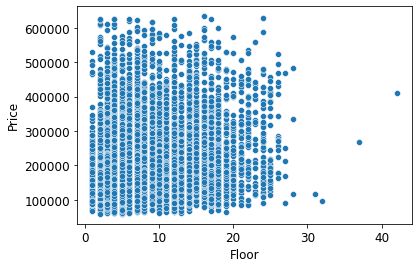

In [158]:
sns.scatterplot(cd_new.Floor, cd_new.Price)

<AxesSubplot:xlabel='HouseFloor', ylabel='Price'>

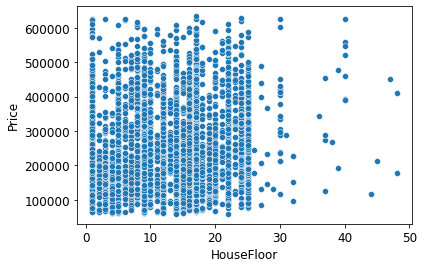

In [159]:
sns.scatterplot(cd_new.HouseFloor, cd_new.Price)

<AxesSubplot:xlabel='HouseYear', ylabel='Price'>

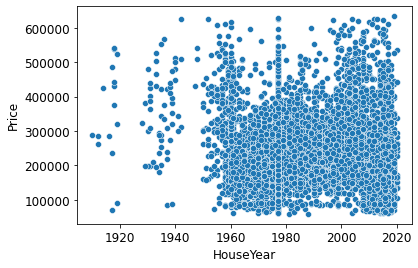

In [160]:
sns.scatterplot(cd_new.HouseYear, cd_new.Price)

<AxesSubplot:xlabel='Ecology_1', ylabel='Price'>

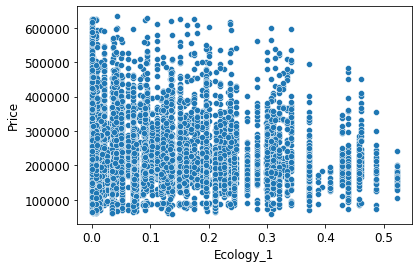

In [161]:
sns.scatterplot(cd_new.Ecology_1, cd_new.Price)

<AxesSubplot:xlabel='Social_1', ylabel='Price'>

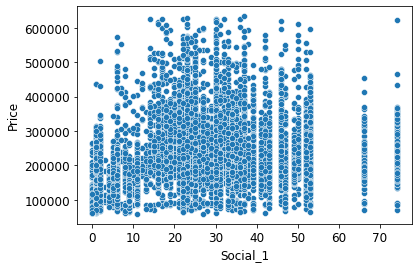

In [162]:
sns.scatterplot(cd_new.Social_1, cd_new.Price)

<AxesSubplot:xlabel='Social_2', ylabel='Price'>

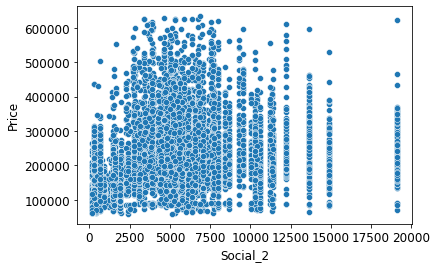

In [163]:
sns.scatterplot(cd_new.Social_2, cd_new.Price)

<AxesSubplot:xlabel='Social_3', ylabel='Price'>

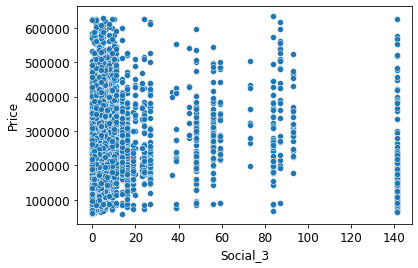

In [164]:
sns.scatterplot(cd_new.Social_3, cd_new.Price)

<AxesSubplot:xlabel='Helthcare_2', ylabel='Price'>

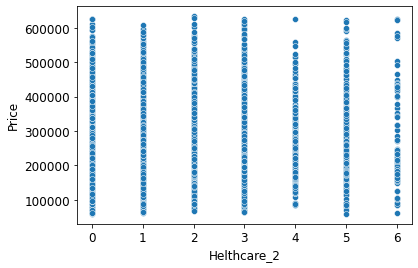

In [165]:
sns.scatterplot(cd_new.Helthcare_2, cd_new.Price)

<AxesSubplot:xlabel='Shops_1', ylabel='Price'>

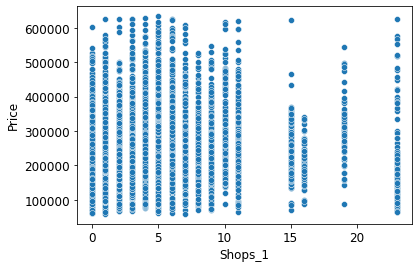

In [166]:
sns.scatterplot(cd_new.Shops_1, cd_new.Price)

<AxesSubplot:xlabel='Shops_2', ylabel='Price'>

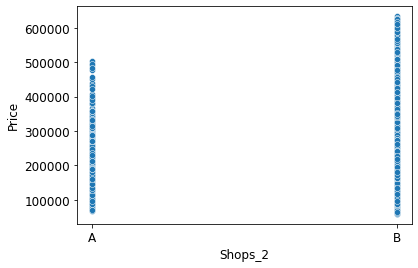

In [167]:
sns.scatterplot(cd_new.Shops_2, cd_new.Price)

Заметная взаимосвязь видна с DictrictId, Square, LifeSquare и HouseYear

### Попробуем другие инструменты визуализации. Например, seaborn

In [168]:
# для установки библиотек

from __future__ import (absolute_import, division,
                        print_function, unicode_literals)
# отключим предупреждения
import warnings
warnings.simplefilter('ignore')

# будем отображать графики прямо в jupyter'e
%pylab inline
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 

#увеличим размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 6,3
import seaborn as sns


Populating the interactive namespace from numpy and matplotlib


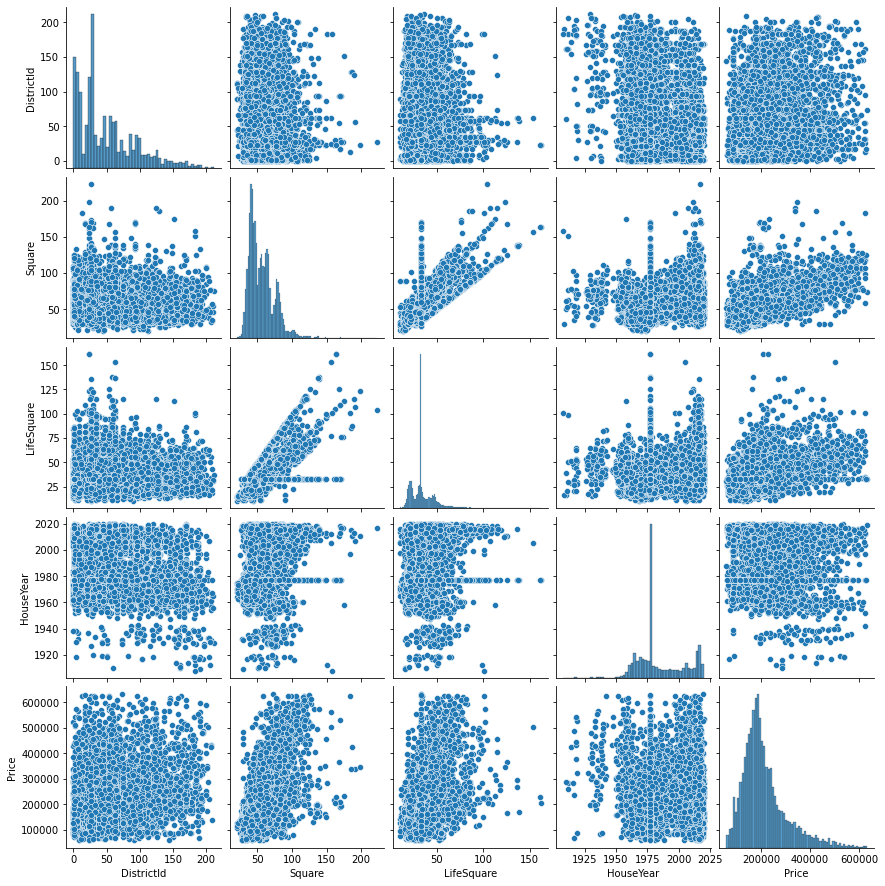

In [169]:
%config InlineBackend.figure_format = 'png' 
sns_plot = sns.pairplot(cd_new[['DistrictId','Square', 'LifeSquare', 'HouseYear', 'Price']]);
sns_plot.savefig('pairplot.png')

Построим матрицу корреляций

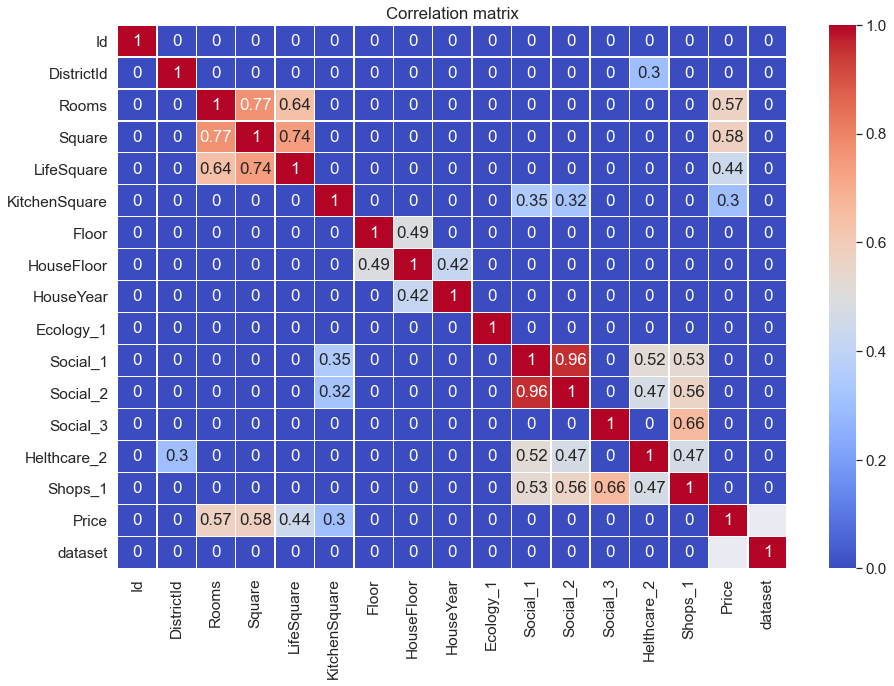

In [170]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = cd_new.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

Заметная взаимосвязь видна с Rooms, Square, LifeSquare, Social_1/2/3 и Healthcare_2

Создаем дополнительные признаки:


In [171]:
# Цена за метр площади
cd_new['PricePerMeter'] = cd_new['Price'] / cd_new['Square']

In [172]:
cd_new['PricePerMeter'].describe()

count    10000.000000
mean      3893.662354
std       1266.544312
min        752.588684
25%       2917.828613
50%       3905.853516
75%       4689.810059
max      16252.216797
Name: PricePerMeter, dtype: float64

In [173]:
cd_new.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,dataset,PricePerMeter
0,14038,35,2.0,47.981560,29.442751,6.0,7,9,1969,0.089040,33,7976,5,0,11,B,184966.937500,0,3854.958740
1,15053,41,3.0,65.683640,40.049541,8.0,7,9,1978,0.000070,46,10309,1,1,16,B,300009.437500,0,4567.491211
2,4765,53,2.0,44.947952,29.197611,0.0,8,12,1968,0.049637,34,7759,0,1,3,B,220925.906250,0,4915.149414
3,5809,58,2.0,53.352982,52.731510,9.0,8,17,1977,0.437885,23,5735,3,0,5,B,175616.234375,0,3291.591797
4,10783,99,1.0,39.649193,23.776169,7.0,11,12,1976,0.012339,35,5776,1,2,4,B,150226.531250,0,3788.892578


In [174]:
# цена за метр в зависимости от района
PricePerMeter_by_Id = cd_new.groupby('DistrictId').agg({'PricePerMeter':'median'}).rename(columns={'PricePerMeter':'PricePerMeter_by_Id'})

In [175]:
cd_new = cd_new.merge(PricePerMeter_by_Id,on='DistrictId',how='left')

In [176]:
cd_new.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,dataset,PricePerMeter,PricePerMeter_by_Id
0,14038,35,2.0,47.981560,29.442751,6.0,7,9,1969,0.089040,33,7976,5,0,11,B,184966.937500,0,3854.958740,4358.274902
1,15053,41,3.0,65.683640,40.049541,8.0,7,9,1978,0.000070,46,10309,1,1,16,B,300009.437500,0,4567.491211,4437.304199
2,4765,53,2.0,44.947952,29.197611,0.0,8,12,1968,0.049637,34,7759,0,1,3,B,220925.906250,0,4915.149414,4845.918945
3,5809,58,2.0,53.352982,52.731510,9.0,8,17,1977,0.437885,23,5735,3,0,5,B,175616.234375,0,3291.591797,2949.975342
4,10783,99,1.0,39.649193,23.776169,7.0,11,12,1976,0.012339,35,5776,1,2,4,B,150226.531250,0,3788.892578,3992.031250


In [177]:
cd_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 0 to 14999
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Id                   15000 non-null  uint16  
 1   DistrictId           15000 non-null  uint8   
 2   Rooms                15000 non-null  float64 
 3   Square               15000 non-null  float32 
 4   LifeSquare           15000 non-null  float32 
 5   KitchenSquare        15000 non-null  float32 
 6   Floor                15000 non-null  uint8   
 7   HouseFloor           15000 non-null  uint8   
 8   HouseYear            15000 non-null  uint32  
 9   Ecology_1            15000 non-null  float32 
 10  Social_1             15000 non-null  uint8   
 11  Social_2             15000 non-null  uint16  
 12  Social_3             15000 non-null  uint8   
 13  Helthcare_2          15000 non-null  uint8   
 14  Shops_1              15000 non-null  uint8   
 15  Shops_2            

Заменим пропуски в PricePerMeter_by_ID

In [178]:
cd_new["PricePerMeter_by_Id"].fillna(cd_new["PricePerMeter_by_Id"].median(),inplace=True)

In [179]:
# проверка
cd_new['PricePerMeter_by_Id'].describe()

count    15000.000000
mean      3932.402100
std        992.949829
min       2273.498779
25%       2938.048340
50%       4134.353516
75%       4562.026367
max       8700.768555
Name: PricePerMeter_by_Id, dtype: float64

In [180]:
#ср.площадб комнаты
cd_new['Room_square'] = cd_new.LifeSquare / cd_new.Rooms

In [181]:
#доля кухни к жилой площади
cd_new['Kit_square'] = cd_new.KitchenSquare / cd_new.LifeSquare

In [182]:
cd_new.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Helthcare_2,Shops_1,Shops_2,Price,dataset,PricePerMeter,PricePerMeter_by_Id,Room_square,Kit_square
0,14038,35,2.0,47.981560,29.442751,6.0,7,9,1969,0.089040,...,5,0,11,B,184966.937500,0,3854.958740,4358.274902,14.721375,0.203785
1,15053,41,3.0,65.683640,40.049541,8.0,7,9,1978,0.000070,...,1,1,16,B,300009.437500,0,4567.491211,4437.304199,13.349847,0.199753
2,4765,53,2.0,44.947952,29.197611,0.0,8,12,1968,0.049637,...,0,1,3,B,220925.906250,0,4915.149414,4845.918945,14.598805,0.000000
3,5809,58,2.0,53.352982,52.731510,9.0,8,17,1977,0.437885,...,3,0,5,B,175616.234375,0,3291.591797,2949.975342,26.365755,0.170676
4,10783,99,1.0,39.649193,23.776169,7.0,11,12,1976,0.012339,...,1,2,4,B,150226.531250,0,3788.892578,3992.031250,23.776169,0.294412


Уберу буквы

In [183]:
cd_new[cd_new['Ecology_1'] == "A"]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Helthcare_2,Shops_1,Shops_2,Price,dataset,PricePerMeter,PricePerMeter_by_Id,Room_square,Kit_square


In [184]:
cd_new[cd_new['Ecology_1'] == "B"]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Helthcare_2,Shops_1,Shops_2,Price,dataset,PricePerMeter,PricePerMeter_by_Id,Room_square,Kit_square


In [185]:
cd_new[cd_new['Shops_2'] == "A"]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Helthcare_2,Shops_1,Shops_2,Price,dataset,PricePerMeter,PricePerMeter_by_Id,Room_square,Kit_square
13,2408,57,3.0,68.102737,39.311493,8.0,6,12,1980,0.133215,...,3,3,4,A,252481.906250,0,3707.367920,4107.652832,13.103831,0.203503
14,10953,27,1.0,53.769096,52.408028,1.0,5,4,1977,0.072158,...,1,0,0,A,140647.562500,0,2615.769531,2761.685303,52.408028,0.019081
18,2829,57,1.0,44.513481,23.113422,8.0,6,12,1983,0.133215,...,3,3,4,A,183743.234375,0,4127.811035,4107.652832,23.113422,0.346119
26,4378,27,3.0,106.958870,68.945686,0.0,17,17,2018,0.072158,...,1,0,0,A,337299.875000,0,3153.547363,2761.685303,22.981895,0.000000
50,2221,170,1.0,35.390236,21.675589,5.0,3,5,1963,0.218440,...,6,4,7,A,172795.859375,0,4882.585449,4949.776367,21.675589,0.230674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14924,7623,57,3.0,74.736778,43.191494,10.0,13,17,1996,0.133215,...,3,3,4,A,NaN,1,NaN,4107.652832,14.397165,0.231527
14939,13952,57,2.0,47.985092,28.684639,5.0,2,5,1972,0.133215,...,3,3,4,A,NaN,1,NaN,4107.652832,14.342319,0.174309
14940,3320,170,1.0,33.693169,18.859938,5.0,1,8,1962,0.218440,...,6,4,7,A,NaN,1,NaN,4949.776367,18.859938,0.265112
14970,1740,57,2.0,47.702000,30.281572,6.0,5,9,1980,0.133215,...,3,3,4,A,NaN,1,NaN,4107.652832,15.140786,0.198140


In [186]:
cd_new[cd_new['Shops_2'] == "B"]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Helthcare_2,Shops_1,Shops_2,Price,dataset,PricePerMeter,PricePerMeter_by_Id,Room_square,Kit_square
0,14038,35,2.0,47.981560,29.442751,6.0,7,9,1969,0.089040,...,5,0,11,B,184966.937500,0,3854.958740,4358.274902,14.721375,0.203785
1,15053,41,3.0,65.683640,40.049541,8.0,7,9,1978,0.000070,...,1,1,16,B,300009.437500,0,4567.491211,4437.304199,13.349847,0.199753
2,4765,53,2.0,44.947952,29.197611,0.0,8,12,1968,0.049637,...,0,1,3,B,220925.906250,0,4915.149414,4845.918945,14.598805,0.000000
3,5809,58,2.0,53.352982,52.731510,9.0,8,17,1977,0.437885,...,3,0,5,B,175616.234375,0,3291.591797,2949.975342,26.365755,0.170676
4,10783,99,1.0,39.649193,23.776169,7.0,11,12,1976,0.012339,...,1,2,4,B,150226.531250,0,3788.892578,3992.031250,23.776169,0.294412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,6836,39,2.0,45.131283,30.780550,6.0,2,5,1965,0.428826,...,8,0,2,B,NaN,1,NaN,4249.133301,15.390275,0.194928
14995,8180,11,3.0,67.133911,50.809795,6.0,5,9,1973,0.000170,...,0,1,1,B,NaN,1,NaN,4134.353516,16.936598,0.118087
14996,4695,1,1.0,40.198471,21.807060,10.0,12,17,2017,0.007122,...,0,0,1,B,NaN,1,NaN,3251.202393,21.807060,0.458567
14997,5783,12,3.0,77.842178,48.282623,9.0,23,22,1989,0.090799,...,2,5,15,B,NaN,1,NaN,4162.240234,16.094208,0.186402


In [187]:
cd_new = pd.get_dummies(cd_new, drop_first=True)

In [188]:
cd_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 0 to 14999
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   15000 non-null  uint16 
 1   DistrictId           15000 non-null  uint8  
 2   Rooms                15000 non-null  float64
 3   Square               15000 non-null  float32
 4   LifeSquare           15000 non-null  float32
 5   KitchenSquare        15000 non-null  float32
 6   Floor                15000 non-null  uint8  
 7   HouseFloor           15000 non-null  uint8  
 8   HouseYear            15000 non-null  uint32 
 9   Ecology_1            15000 non-null  float32
 10  Social_1             15000 non-null  uint8  
 11  Social_2             15000 non-null  uint16 
 12  Social_3             15000 non-null  uint8  
 13  Helthcare_2          15000 non-null  uint8  
 14  Shops_1              15000 non-null  uint8  
 15  Price                10000 non-null 

#### Прологарифмируем данные

In [189]:
feature_name = ['Rooms','Square','LifeSquare','KitchenSquare']
feature_name_log = []
for i in feature_name:
    cd_new[i +'_log'] = np.log(cd_new[i])
    feature_name_log.append(i + '_log')

In [190]:
cd_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 0 to 14999
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id                   15000 non-null  uint16 
 1   DistrictId           15000 non-null  uint8  
 2   Rooms                15000 non-null  float64
 3   Square               15000 non-null  float32
 4   LifeSquare           15000 non-null  float32
 5   KitchenSquare        15000 non-null  float32
 6   Floor                15000 non-null  uint8  
 7   HouseFloor           15000 non-null  uint8  
 8   HouseYear            15000 non-null  uint32 
 9   Ecology_1            15000 non-null  float32
 10  Social_1             15000 non-null  uint8  
 11  Social_2             15000 non-null  uint16 
 12  Social_3             15000 non-null  uint8  
 13  Helthcare_2          15000 non-null  uint8  
 14  Shops_1              15000 non-null  uint8  
 15  Price                10000 non-null 

In [191]:
#уберем ID
cd_new.drop(columns='Id',inplace=True)

### Построим модель

In [192]:
#разделим набор данных на учебный и валидный
X_train_1 = cd_new[cd_new['dataset'] == 0]
X_test = cd_new[cd_new['dataset'] == 1]

In [193]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 10000 to 14999
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DistrictId           5000 non-null   uint8  
 1   Rooms                5000 non-null   float64
 2   Square               5000 non-null   float32
 3   LifeSquare           5000 non-null   float32
 4   KitchenSquare        5000 non-null   float32
 5   Floor                5000 non-null   uint8  
 6   HouseFloor           5000 non-null   uint8  
 7   HouseYear            5000 non-null   uint32 
 8   Ecology_1            5000 non-null   float32
 9   Social_1             5000 non-null   uint8  
 10  Social_2             5000 non-null   uint16 
 11  Social_3             5000 non-null   uint8  
 12  Helthcare_2          5000 non-null   uint8  
 13  Shops_1              5000 non-null   uint8  
 14  Price                0 non-null      float32
 15  dataset              5000 non-nul

In [194]:
y_test = X_test.Price

In [195]:
y_train = X_train_1.Price
X_train= X_train_1.drop(columns=['Price','PricePerMeter'])

In [196]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DistrictId           10000 non-null  uint8  
 1   Rooms                10000 non-null  float64
 2   Square               10000 non-null  float32
 3   LifeSquare           10000 non-null  float32
 4   KitchenSquare        10000 non-null  float32
 5   Floor                10000 non-null  uint8  
 6   HouseFloor           10000 non-null  uint8  
 7   HouseYear            10000 non-null  uint32 
 8   Ecology_1            10000 non-null  float32
 9   Social_1             10000 non-null  uint8  
 10  Social_2             10000 non-null  uint16 
 11  Social_3             10000 non-null  uint8  
 12  Helthcare_2          10000 non-null  uint8  
 13  Shops_1              10000 non-null  uint8  
 14  dataset              10000 non-null  int64  
 15  PricePerMeter_by_Id  10000 non-null  

In [197]:
features = ['DistrictId','Rooms', 'Square', 'LifeSquare', 'KitchenSquare','Floor',
       'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2',
       'Social_3', 'Helthcare_2', 'Shops_1', 'dataset', 'PricePerMeter_by_Id',
       'Room_square', 'Kit_square', 'Shops_2_B']

In [198]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DistrictId           10000 non-null  uint8  
 1   Rooms                10000 non-null  float64
 2   Square               10000 non-null  float32
 3   LifeSquare           10000 non-null  float32
 4   KitchenSquare        10000 non-null  float32
 5   Floor                10000 non-null  uint8  
 6   HouseFloor           10000 non-null  uint8  
 7   HouseYear            10000 non-null  uint32 
 8   Ecology_1            10000 non-null  float32
 9   Social_1             10000 non-null  uint8  
 10  Social_2             10000 non-null  uint16 
 11  Social_3             10000 non-null  uint8  
 12  Helthcare_2          10000 non-null  uint8  
 13  Shops_1              10000 non-null  uint8  
 14  dataset              10000 non-null  int64  
 15  PricePerMeter_by_Id  10000 non-null  

In [199]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train.loc[:, features]), columns=features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test.loc[:, features]), columns=features)

Модель линейной регрессии:

In [200]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)


LinearRegression()

Text(0, 0.5, 'Признак')

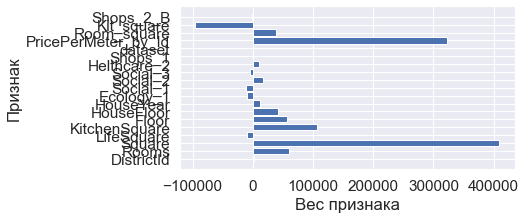

In [201]:
plt.barh(features, lr.coef_.flatten())

plt.xlabel("Вес признака")
plt.ylabel("Признак")

In [202]:
from sklearn.metrics import r2_score


In [203]:
y_pred_train_lr = lr.predict(X_train_scaled)


In [204]:
r2_score(y_train, y_pred_train_lr)

0.6774624139500063

RandomForestRegressor

In [205]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV

params = {'n_estimators': [250, 300, 350],
          'max_features': np.arange(3, 8),
          'max_depth': np.arange(7, 9)}

reg = GridSearchCV(estimator=RandomForestRegressor(random_state=100),
                   param_grid=params,
                   n_jobs=-1,
                   scoring='r2',
                   cv=5,)

In [207]:
plt.barh(features, reg.features)

plt.xlabel("Вес признака")
plt.ylabel("Признак")

AttributeError: 'GridSearchCV' object has no attribute 'features'

In [208]:
y_pred_train_rf = reg.predict(X_train.loc[:, features])
r2_score(y_train, y_pred_train_rf)

NotFittedError: This GridSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.